In [1]:
# Import Libraries
import cv2
import numpy as np
import mahotas
import matplotlib.pyplot as plt

In [2]:
def color_preprocess_image(bgr_img):
  
    hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    
    # Define two red ranges in HSV
    lower_red1 = np.array([0, 100, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 100, 50])
    upper_red2 = np.array([180, 255, 255])
    
    # Create masks for each range, then combine
    mask1 = cv2.inRange(hsv_img, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)
    
    # Morphological closing to remove small holes or noise
    kernel = np.ones((5, 5), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask_clean



In [3]:
def compute_zernike(mask, contour, degree=8):
   
    x, y, w, h = cv2.boundingRect(contour)
    # Crop the mask to the bounding box
    crop = mask[y:y+h, x:x+w]
    # Convert crop to 0/1 instead of 0/255
    crop = (crop > 0).astype(np.uint8)
    
    # Use half the smallest dimension as the radius
    radius = min(w, h) // 2
    if radius <= 0:
        return None, (x, y, w, h)
    
    # Compute Zernike moments using mahotas
    zernike_vector = mahotas.features.zernike_moments(crop.astype(np.float32), radius, degree=degree)
    return zernike_vector, (x, y, w, h)




In [4]:
# PART 2: PROCESS THE REFERENCE (SINGLE) APPLE IMAGE
ref_path = 'apple.jpg'  
ref_img = cv2.imread(ref_path)
if ref_img is None:
    raise ValueError(f"Could not open the reference image: {ref_path}")

# 1. Preprocess the reference image to isolate red regions (the apple).
ref_mask = color_preprocess_image(ref_img)

# 2. Find contours in the reference mask.
ref_contours, _ = cv2.findContours(ref_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not ref_contours:
    raise ValueError("No red contour found in the reference apple image. Adjust your HSV or check the image.")

# 3. Assume the largest contour is the apple in the reference image.
largest_ref_contour = max(ref_contours, key=cv2.contourArea)

# 4. Compute Zernike moments for this reference apple.
ref_moments, ref_bbox = compute_zernike(ref_mask, largest_ref_contour)
if ref_moments is None:
    raise ValueError("Could not compute Zernike moments for the reference apple.")


In [5]:
# PART 3: PROCESS THE GROUP IMAGE WITH MULTIPLE FRUITS
group_path = 'fruits.jpg'  
group_img = cv2.imread(group_path)
if group_img is None:
    raise ValueError(f"Could not open the group image: {group_path}")

# 1. Preprocess the group image to isolate red regions (potential apples).
group_mask = color_preprocess_image(group_img)

# 2. Find contours in the group mask.
group_contours, _ = cv2.findContours(group_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# COMPARE EACH RED REGION TO THE REFERENCE APPLE USING ZERNIKE MOMENTS
best_distance = float('inf')
best_bbox = None

for cnt in group_contours:
    if cv2.contourArea(cnt) < 100:
        continue
    
    zernike_vector, bbox = compute_zernike(group_mask, cnt)
    if zernike_vector is None:
        continue
    
    # Compute Euclidean distance 
    distance = np.linalg.norm(ref_moments - zernike_vector)
    
    if distance < best_distance:
        best_distance = distance
        best_bbox = bbox

result_img = group_img.copy()
if best_bbox is not None:
    x_best, y_best, w_best, h_best = best_bbox
    cv2.rectangle(result_img, (x_best, y_best), (x_best + w_best, y_best + h_best), (0, 255, 0), 3)
else:
    print("No matching apple found. Consider adjusting HSV or thresholding parameters.")


ref_rgb = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)



(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

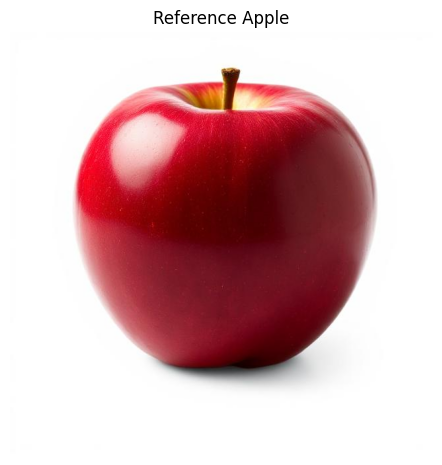

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ref_rgb)
plt.title("Reference Apple")
plt.axis('off')

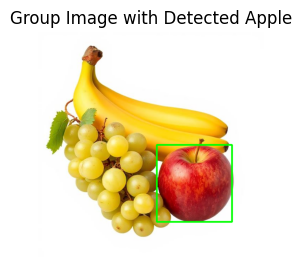

In [7]:
plt.subplot(1, 2, 2)
plt.imshow(result_rgb)
plt.title("Group Image with Detected Apple")
plt.axis('off')

plt.show()